In [1]:
import numpy as np

# Loading the dataset
dataset = np.load('qm7x_eq.npz', allow_pickle=True)

# What is inside?
for f in dataset.files:
    print(f)

EAT
S
xyz
Z


In [2]:
# Importing data
EAT = dataset['EAT'] # atomization energy
xyz = dataset['xyz'] # Cartesian coordinates
Z = dataset['Z'] # atomic indexes

n_molecules = len(xyz)
print('The number of molecules in the dataset is {:d}.'.format(n_molecules))

The number of molecules in the dataset is 41537.


In [3]:
from tqdm import tqdm
from scipy.spatial.distance import pdist

# Descriptor
def descriptor(R):
    
    nconfig = len(R)
    D = []
    for i in tqdm(range(nconfig)):
        D.append(1./pdist(R[i]))
    
    return D

d = descriptor(xyz)

# Making all descriptor entries of the same size
max_size = np.max([len(_) for _ in d])
nconfig = len(d)
D = np.zeros((nconfig, max_size))

for i in range(nconfig):
    size = len(d[i])
    D[i, :size] = d[i]

100%|██████████| 41537/41537 [00:00<00:00, 72287.08it/s]


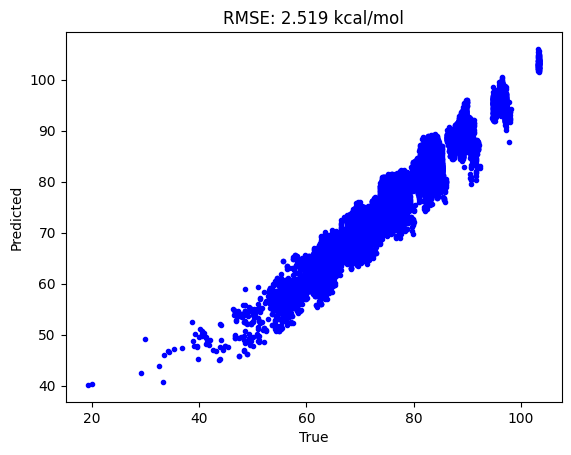

In [4]:
from sklearn import linear_model
import matplotlib.pyplot as plt

# ridge regression
reg = linear_model.Ridge(alpha=1e-8)
reg.fit(D, EAT)

rmse = np.sqrt(np.square(EAT - reg.predict(D)).mean())
plt.title('RMSE: {:.3f} kcal/mol'.format(rmse))
plt.scatter(EAT, reg.predict(D), marker='.', color='blue')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

In [ ]:
import numpy as np
from tqdm import tqdm
from scipy.spatial.distance import pdist
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Loading the dataset
dataset = np.load('qm7x_eq.npz', allow_pickle=True)

# Importing data
EAT = dataset['EAT'] # atomization energy
xyz = dataset['xyz'] # Cartesian coordinates
Z = dataset['Z'] # atomic numbers

# --- Descriptor ---
# For each molecule we build a fixed-length vector made of three parts:
#
# 1. ATOM COUNTS (one value per unique element in the dataset)
#    e.g. [n_H, n_C, n_N, n_O, n_S]
#    These act as a coarse composition fingerprint.
#
# 2. CM DIAGONAL (one value per atom, sorted descending)
#    0.5 * Z_i^2.4  -- the Coulomb Matrix self-interaction term.
#    It encodes the atomic self-energy of each atom.
#    Sorting makes it permutation-invariant.
#
# 3. CM OFF-DIAGONAL grouped by element pair (sorted within each group)
#    Z_i * Z_j / r_ij  -- the Coulomb Matrix interaction term.
#    Grouping by (min(Z_i,Z_j), max(Z_i,Z_j)) and sorting within each
#    group gives permutation invariance: swapping two atoms of the same
#    element type does not change the descriptor.
#    This is physically motivated: the energy depends on which elements
#    are interacting and how far apart they are, not on their arbitrary
#    labelling order.
def descriptor(R):
    uniqueZ = np.sort(np.unique(np.concatenate(Z))).astype(int)
    pairs = [(a, b) for idx, a in enumerate(uniqueZ) for b in uniqueZ[idx:]]
    nconfig = len(R)
    D = []
    for i in tqdm(range(nconfig)):
        Zi = Z[i].astype(float)
        n = len(Zi)
        dists = pdist(R[i])
        # Z_i * Z_j / r_ij for every pair (CM off-diagonal values)
        charges = np.array([Zi[a] * Zi[b] for a in range(n-1) for b in range(a+1, n)])
        Rinv = charges / dists
        # element-pair label (lo, hi) for each atom pair
        keys = np.array([[min(int(Zi[a]), int(Zi[b])), max(int(Zi[a]), int(Zi[b]))]
                         for a in range(n-1) for b in range(a+1, n)])
        # group by element pair and sort within each group
        parts = []
        for (a, b) in pairs:
            mask = (keys[:, 0] == a) & (keys[:, 1] == b)
            if np.any(mask):
                parts.append(np.sort(Rinv[mask]))
        # CM diagonal: 0.5 * Z^2.4, sorted descending
        diagonal = np.sort(0.5 * Zi ** 2.4)[::-1]
        counts = np.array([(Zi == z).sum() for z in uniqueZ])
        D.append(np.concatenate((counts, diagonal, np.concatenate(parts))))
    return D

d = descriptor(xyz)

# Pad all descriptors to the same length
max_size = np.max([len(_) for _ in d])
nconfig = len(d)
D = np.zeros((nconfig, max_size))
for i in range(nconfig):
    size = len(d[i])
    D[i, :size] = d[i]

# --- Train/test split ---
# Without this, RMSE is measured on training data (memorisation, not learning).
# test_size=0.2 holds out 20% of molecules for honest evaluation.
D_train, D_test, EAT_train, EAT_test = train_test_split(D, EAT, test_size=0.2, random_state=42)

# Ridge regression
reg = linear_model.Ridge(alpha=1e-8)
reg.fit(D_train, EAT_train)

rmse_train = np.sqrt(np.square(EAT_train - reg.predict(D_train)).mean())
rmse_test  = np.sqrt(np.square(EAT_test  - reg.predict(D_test)).mean())
print(f'Train RMSE: {rmse_train:.3f} kcal/mol')
print(f'Test  RMSE: {rmse_test:.3f} kcal/mol')

plt.title(f'Test RMSE: {rmse_test:.3f} kcal/mol')
plt.scatter(EAT_test, reg.predict(D_test), marker='.', color='blue', alpha=0.3)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.show()

  0%|          | 2/41537 [00:06<38:44:27,  3.36s/it]


KeyboardInterrupt: 